In [1]:
import os
import sys
sys.path.append('../src')
sys.path.append('../utility')
import importlib

import pandas as pd
import plotly.graph_objects as go
from matplotlib import pyplot as plt

import macd
importlib.reload(macd)
from comment_preprocessing import reformat_time
from matplotlib_wrapper import plot_timeseries, bar_timeseries

In [4]:
video_id_list = [
    "RPqSnJez-YI",
    "-sJSuDcPKRw",
    "HCsLM8I-ZEg",
    "c6od-g02MLk"
]
file = os.path.join("../data/comments", video_id_list[0]+".tsv")
print(file)
df = pd.read_csv(file, sep="\t")
df = df[~df.publishedAt.str.startswith('-')]
df.index = pd.to_timedelta(df.apply(lambda x: reformat_time(x.publishedAt), axis=1))
df['freq'] = 1

../data/comments/RPqSnJez-YI.tsv


In [5]:
df.head()

,publishedAt,displayName,displayMessage,freq
00:00:01,0:01,カイ,当たっていい 当たっていい,1
00:00:01,0:01,りっきー,やあ,1
00:00:02,0:02,サムライ。,なにやってんだよ,1
00:00:02,0:02,宮腰遼,はよセイー,1
00:00:02,0:02,ああ,はよｾｲｰ,1


In [125]:
df.index

TimedeltaIndex(['00:00:01', '00:00:01', '00:00:02', '00:00:02', '00:00:02',
                '00:00:02', '00:00:02', '00:00:03', '00:00:03', '00:00:03',
                ...
                '10:09:54', '10:09:54', '10:09:54', '10:09:54', '10:09:54',
                '10:09:55', '10:09:55', '10:09:55', '10:09:56', '10:09:56'],
               dtype='timedelta64[ns]', length=111425, freq=None)

In [133]:
df.index.total_seconds().astype(int)

Int64Index([    1,     1,     2,     2,     2,     2,     2,     3,     3,
                3,
            ...
            36594, 36594, 36594, 36594, 36594, 36595, 36595, 36595, 36596,
            36596],
           dtype='int64', length=111425)

### コメントの頻度をグラフに可視化

In [188]:
freq = df.index.total_seconds().astype(int).value_counts(sort=False).sort_index()

### 1秒単位で可視化

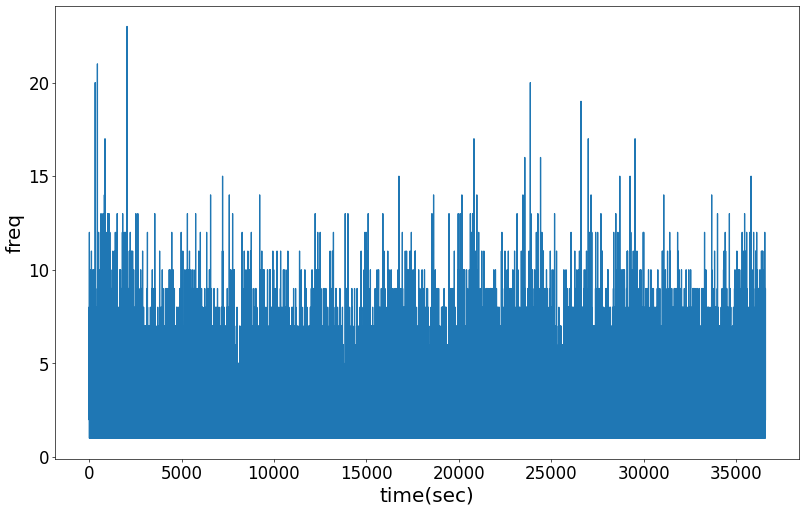

In [194]:
# fig = go.Figure(data=[
#     go.Scatter(x=freq.index, y=freq.values, name="freq")
# ])
# fig.show()

x = freq.index
y = freq.values
plot_timeseries(x, y)

### 15秒単位でサンプリングして可視化

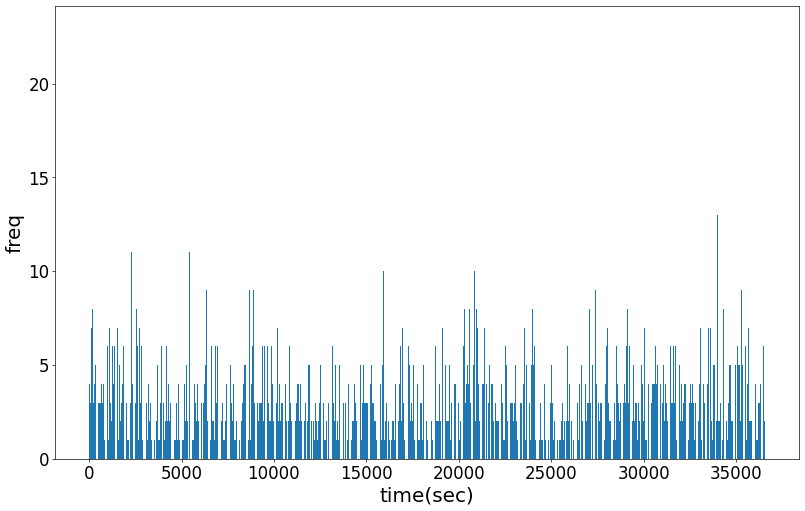

In [232]:
resampled = df['freq'].resample("15s").sum()
x = resampled.index.total_seconds().astype(int)
y = resampled.values
bar_timeseries(x, y)

### MACDを計算して表示してみる

In [250]:
macd_hist = macd.calc_macd(x, y, f=26, s=12, t=9)

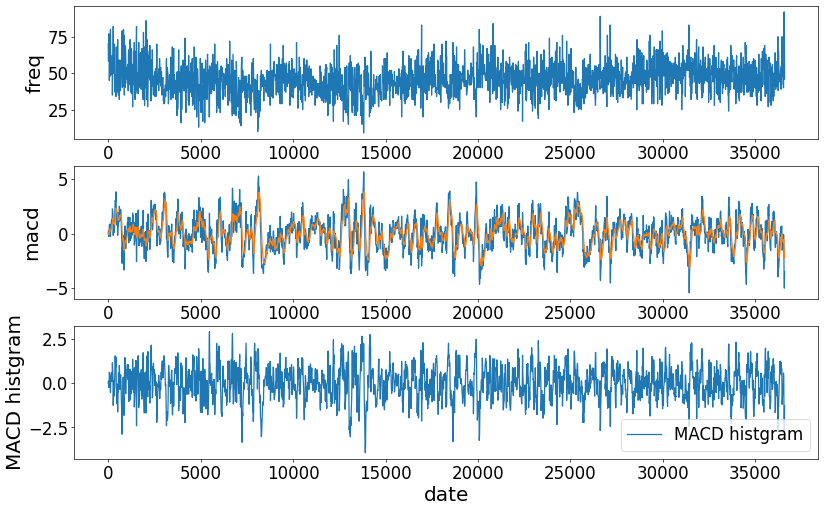

In [253]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10), dpi=60)
ax1.plot(macd_hist.index, macd_hist['freq'], label='freq')
ax2.plot(macd_hist.index, macd_hist['macd'], label='macd')
ax2.plot(macd_hist.index, macd_hist['signal'], label='signal')
ax3.plot(macd_hist.index, macd_hist['hist'], label='MACD histgram')

ax1.set_xlabel('date', fontsize=24)
ax1.set_ylabel('freq', fontsize=24)
ax1.tick_params(labelsize=20)
ax2.set_xlabel('date', fontsize=24)
ax2.set_ylabel('macd', fontsize=24)
ax2.tick_params(labelsize=20)
ax3.set_xlabel('date', fontsize=24)
ax3.set_ylabel('MACD histgram', fontsize=24)
ax3.tick_params(labelsize=20)
plt.legend(fontsize=20)
plt.show()

# 実際に該当箇所の動画を抽出してみる

In [303]:
macd_hist['url'] = ['https://www.youtube.com/watch?v=RPqSnJez-YI&t=%s&end=%s' % (t-30, t+30) for t in macd_hist.sort_values('freq', ascending=False).index]
macd_hist.sort_values('freq', ascending=False)[['freq', 'hist', 'url']].head()

,freq,hist,url
36556,92,-2.358412,https://www.youtube.com/watch?v=RPqSnJez-YI&t=...
26611,89,-2.663270,https://www.youtube.com/watch?v=RPqSnJez-YI&t=...
2041,86,-1.684137,https://www.youtube.com/watch?v=RPqSnJez-YI&t=...
20821,84,-1.177006,https://www.youtube.com/watch?v=RPqSnJez-YI&t=...
16951,83,-2.137287,https://www.youtube.com/watch?v=RPqSnJez-YI&t=...


In [304]:
['https://www.youtube.com/watch?v=RPqSnJez-YI&t=%s&end=%s' % (t-30, t+30) for t in macd_hist.sort_values('freq', ascending=False).index][:5]

['https://www.youtube.com/watch?v=RPqSnJez-YI&t=36526&end=36586',
 'https://www.youtube.com/watch?v=RPqSnJez-YI&t=26581&end=26641',
 'https://www.youtube.com/watch?v=RPqSnJez-YI&t=2011&end=2071',
 'https://www.youtube.com/watch?v=RPqSnJez-YI&t=20791&end=20851',
 'https://www.youtube.com/watch?v=RPqSnJez-YI&t=16921&end=16981']

### MACD降順にバースト箇所を抽出してyoutubeの動画の時間を指定する
- バースト時間前後30秒を選択する

In [299]:
macd_hist['url'] = ['https://www.youtube.com/watch?v=RPqSnJez-YI&t=%s&end=%s' % (t-30, t+30) for t in macd_hist.sort_values('hist', ascending=False).index]
macd_hist.sort_values('hist', ascending=True)[['freq', 'hist', 'url']].head()

,freq,hist,url
13906,56,-3.928404,https://www.youtube.com/watch?v=RPqSnJez-YI&t=...
13891,61,-3.556672,https://www.youtube.com/watch?v=RPqSnJez-YI&t=...
13921,48,-3.453261,https://www.youtube.com/watch?v=RPqSnJez-YI&t=...
7231,61,-3.336821,https://www.youtube.com/watch?v=RPqSnJez-YI&t=...
18646,71,-3.295037,https://www.youtube.com/watch?v=RPqSnJez-YI&t=...


In [300]:
['https://www.youtube.com/watch?v=RPqSnJez-YI&t=%s&end=%s' % (t-30, t+30) for t in macd_hist.sort_values('hist', ascending=True).index][:5]

['https://www.youtube.com/watch?v=RPqSnJez-YI&t=13876&end=13936',
 'https://www.youtube.com/watch?v=RPqSnJez-YI&t=13861&end=13921',
 'https://www.youtube.com/watch?v=RPqSnJez-YI&t=13891&end=13951',
 'https://www.youtube.com/watch?v=RPqSnJez-YI&t=7201&end=7261',
 'https://www.youtube.com/watch?v=RPqSnJez-YI&t=18616&end=18676']